In [1]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
# from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
# from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

from tensorflow.keras.optimizers import Adam, SGD # - Works


from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_path = '/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/train'

diag_code_dict = {
    'COVID': 0,
    'Normal': 1,
    'Viral Pneumonia': 2}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(train_path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','train_path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [ ]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 0
Number of duplicated values: 0
Number of Null samples: 0


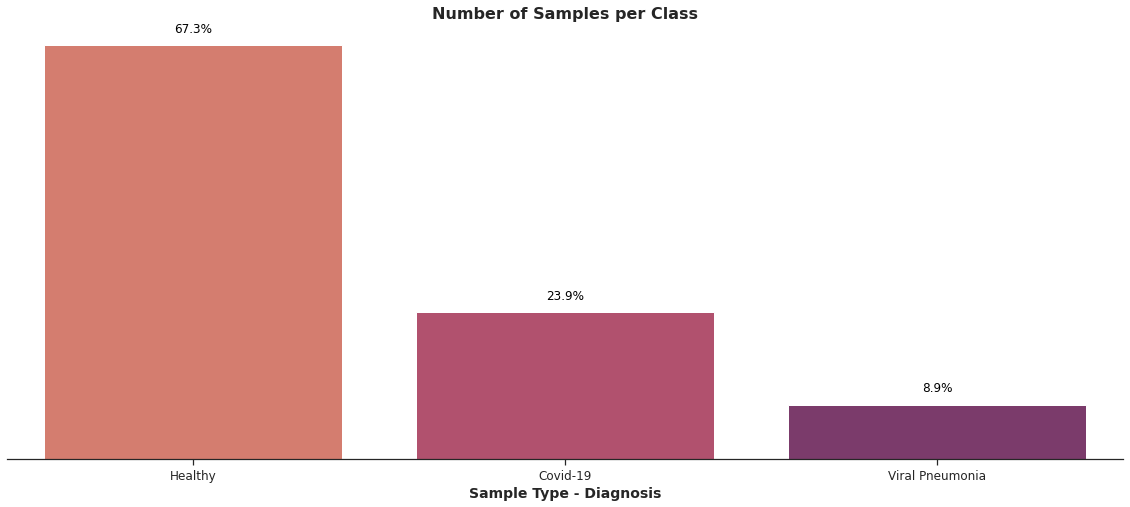

In [ ]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [ ]:
# covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [ ]:
train_path = '/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/train'
test_path = '/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/test'
val_path = '/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/val'

In [ ]:
#Define the parameters to create the training and validation set Images and Data Augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255)


test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 16

train_gen = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224), 
                                                 batch_size = batch_size,
                                                 shuffle=True, 
                                                 class_mode = "categorical")

val_gen = val_datagen.flow_from_directory(val_path,
                                          target_size = (224, 224),
                                          batch_size = batch_size,
                                          shuffle=True,
                                          class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 12121 images belonging to 3 classes.
Found 1514 images belonging to 3 classes.
Found 1518 images belonging to 3 classes.


In [ ]:
# checking the index of classes
classes = train_gen.class_indices    
print(classes)

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# 1st: Kaggle Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 3)))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
#Compile the model
opt = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

In [ ]:
#Model Parameters
epochs = 100

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 10, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=10,monitor='val_loss', mode = 'min',verbose=1)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(val_gen) // batch_size, 
                                validation_data=val_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
# y_pred = model.predict(test_gen)
model.save('/content/drive/MyDrive/Final_Covid/COVID-19_Radiography_Dataset/saved_model/Kagglemodel.h5')

Epoch 1/100
47/47 [==============================] - 48s 1s/step - loss: 0.5329 - recall_1: 0.7487 - val_loss: 0.4157 - val_recall_1: 0.8250 - lr: 5.0000e-04
Epoch 2/100
47/47 [==============================] - 51s 1s/step - loss: 0.5030 - recall_1: 0.7473 - val_loss: 0.4098 - val_recall_1: 0.8125 - lr: 5.0000e-04
Epoch 3/100
47/47 [==============================] - 40s 861ms/step - loss: 0.5619 - recall_1: 0.7329 - val_loss: 0.5431 - val_recall_1: 0.8000 - lr: 5.0000e-04
Epoch 4/100
47/47 [==============================] - 47s 999ms/step - loss: 0.5470 - recall_1: 0.7340 - val_loss: 0.2715 - val_recall_1: 0.8875 - lr: 5.0000e-04
Epoch 5/100
47/47 [==============================] - 44s 937ms/step - loss: 0.5123 - recall_1: 0.7527 - val_loss: 0.3202 - val_recall_1: 0.8375 - lr: 5.0000e-04
Epoch 6/100
47/47 [==============================] - 40s 841ms/step - loss: 0.5140 - recall_1: 0.7434 - val_loss: 0.3848 - val_recall_1: 0.8125 - lr: 5.0000e-04
Epoch 7/100
47/47 [=====================

In [ ]:
# Model performance graph

In [ ]:
# Model calassification report

# VGG16

In [ ]:
import tensorflow as tf

In [ ]:
from keras.applications.vgg16 import VGG16


In [ ]:
model_vgg16 = Sequential()
model_vgg16.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Flatten())
model_vgg16.add(Dense(units=4096,activation="relu"))
model_vgg16.add(Dense(units=4096,activation="relu"))
model_vgg16.add(Dense(units=3, activation="softmax"))


In [ ]:

print(model_vgg16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                    

In [ ]:
opt = Adam(learning_rate=0.01)
model_vgg16.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
#Model Parameters
epochs = 100

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 10, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=15 ,monitor='val_loss', mode = 'min',verbose=1)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history1 = model_vgg16.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(val_gen) // batch_size, 
                                validation_data=val_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
# y_pred = model.predict(test_gen)
model.save('/content/drive/MyDrive/Final_Covid/COVID-19_Radiography_Dataset/saved_model/VGG16.h5')

In [ ]:
...
# list all data in history
print(history1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


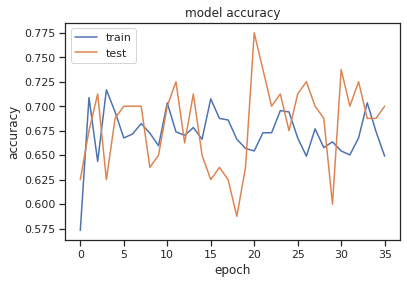

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

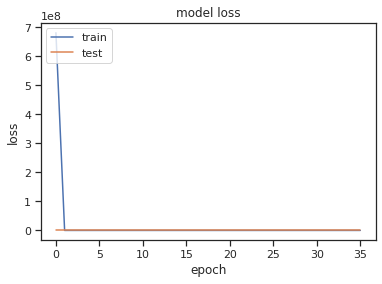

In [ ]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Classification report
predictions = model_vgg16.predict(test_gen)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_gen, predictions))

# Pre-Trained VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(3, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=5e-5)
early_stopping_monitor = EarlyStopping(patience=4 ,monitor='val_accuracy', mode = 'auto',verbose=1)


checkpoint = ModelCheckpoint('/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/vgg16_finetune3.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history2 = transfer_model.fit(train_gen,
                              validation_data=val_gen,
                              batch_size = 1, 
                              epochs=50, 
                              callbacks=[lr_reduce,early_stopping_monitor,checkpoint])
transfer_model.save('/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/Pretrained_VGG16.h5')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
758/758 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8560
Epoch 00001: val_accuracy improved from -inf to 0.87120, saving model to /content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/vgg16_finetune3.h15
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/vgg16_finetune3.h15/assets
758/758 [==============================] - 2562s 3s/step - loss: 0.3716 - accuracy: 0.8560 - val_loss: 0.4536 - val_accuracy: 0.8712 - lr: 5.0000e-05
Epoch 2/50
758/758 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9222
Epoch 00002: val_accuracy improved from 0.87120 to 0.96235, saving model to /content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/vgg16_finetune3.h15
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/vgg16_finetune3.h15/assets
758/758 [==============================] - 246s 324ms/step - loss: 0.

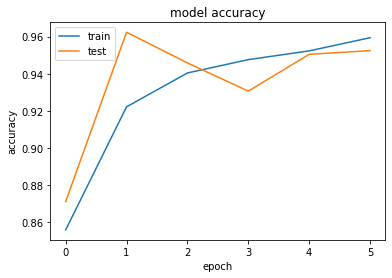

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

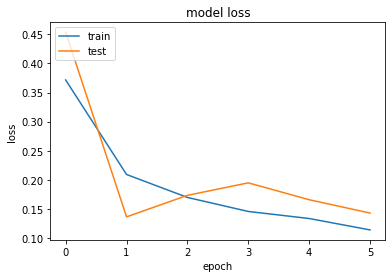

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Classification report
predictions = transfer_model.predict_generator(test_gen)


# Classification Report
from sklearn.metrics import classification_report
# print(classification_report(test_gen, predictions))

# Loading Saved Model

In [ ]:
# Modify 'test1.jpg' and 'test2.jpg' to the images you want to predict on

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
# img_width, img_height, channel = 256, 256, 3

# load the model we saved
model = load_model('/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/Pretrained_VGG16.h5')
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# predicting images
img = image.load_img('/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/test/COVID/COVID-2620.png', target_size=(224, 224, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classe = model.predict(images, batch_size=10)
print("first image output: ", classe)


first image output:  [[1. 0. 0.]]


In [ ]:
model.summary()

In [ ]:
classes = train_gen.class_indices    
print(classes)

## Heatmap 

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf

import numpy as np
import imutils
import cv2

In [ ]:
# load the pre-trained CNN from disk
model = load_model('/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/saved_model/Pretrained_VGG16.h5')

In [ ]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread("/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/test/COVID/COVID-2620.png")
resized = cv2.resize(orig, (224, 224))

In [ ]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img("/content/drive/MyDrive/data/COVID-19_Radiography_Dataset/Train_Split_Test/test/COVID/COVID-2620.png", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
image = np.vstack([image])

In [ ]:
# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

In [ ]:
print(preds)

[[1. 0. 0.]]


In [ ]:
# decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(classe)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])
              # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

In [ ]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [ ]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
# cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
#output = np.vstack([resized, heatmap, output])
output = imutils.resize(output, height=700)
#cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
filename = 'xray_covid.png'
cv2.imwrite(filename, output)

True

In [ ]:
cv2